In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [98]:
tops=pd.read_csv(r'D:\jonahtops.csv')
tops.ssdepth.min()

-11183

In [99]:
tops.ssdepth = tops.ssdepth-tops.ssdepth.min()

In [100]:
tops.head()

,api,formation,depth,ssdepth
0,3521913,WASATCH,0,18464
1,3521913,LANCE,9285,9179
2,3521913,JONAH,11227,7237
3,3521913,YELLOWPOINT,11793,6671
4,3521913,WARDELL,12139,6325


In [101]:
data=np.asarray(tops[['api', 'formation', 'ssdepth']])
tops['depth'].max()

18245

In [102]:
D_df = tops.pivot_table('ssdepth', 'formation', 'api').fillna(0)

In [103]:
R =D_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [104]:
from sklearn.preprocessing import binarize
A=binarize(R)

In [118]:
def runALS(A, R, n_factors, n_iterations, lambda_):
    '''
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    '''
    print("Initiating ")
    lambda_ = 0.1; n_factors = 20; n, m = A.shape; n_iterations = 30
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Items, np.dot(np.diag(Ri), A[i].T))).T
        print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

        for j, Rj in enumerate(R.T):
            Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambda_ * np.eye(n_factors),
                                     np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])))
        print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

        MSE_List.append(get_error(A, Users, Items, R))
        print('%sth iteration is complete...' % iter)
    return Users, Items
    #print(MSE_List)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    #plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    #plt.savefig('Python MSE Graph.pdf', format='pdf')
    #plt.show()

In [119]:
U, Vt = runALS(R, A, 10, 100, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 4021996.629675355
Error after solving for Item Matrix: 8.359121405468886e-05
0th iteration is complete...
Error after solving for User Matrix: 10.737059836361237
Error after solving for Item Matrix: 8.348957417711136e-05
1th iteration is complete...
Error after solving for User Matrix: 3.065720063908119
Error after solving for Item Matrix: 8.348451905510474e-05
2th iteration is complete...
Error after solving for User Matrix: 2.4453131726045156
Error after solving for Item Matrix: 8.347862530936795e-05
3th iteration is complete...
Error after solving for User Matrix: 2.168296203313467
Error after solving for Item Matrix: 8.347256353657049e-05
4th iteration is complete...
Error after solving for User Matrix: 1.9406175371304346
Error after solving for Item Matrix: 8.346648855263123e-05
5th iteration is complete...
Error after solving for User Matrix: 1.7454304935921916
Error after solving for Item Matrix: 8.346045414409

In [133]:
recommendations = np.dot(U, Vt)

In [134]:
recsys = pd.DataFrame(data=recommendations[0:,0:], index=D_df.index, columns=D_df.columns) 

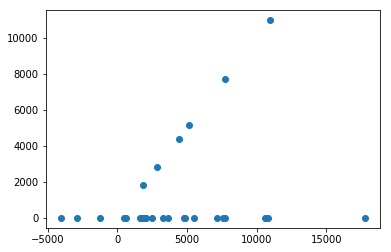

In [135]:
plt.scatter(recsys.iloc[0:,1].values, D_df.iloc[0:,1].values)

In [136]:
recsys.iloc[0:,1]

formation
ALMOND              7129.299965
ASPEN              -2878.226510
BACON RIDGE         2836.968654
BASE FORT UNION    -4068.605812
BAXTER             -1249.670505
BENCH               2005.559831
BLAIR               5531.145756
DAKOTA               481.134169
ERICSON             5180.000000
FORT  UNION        10591.963794
FORT UNION         10987.000000
FRONTIER             593.977060
HILLIARD            1841.329257
JONAH               3280.312025
LANCE               7729.000000
LANE LOWER          4749.472905
LANEC FM           10794.734831
LANEY               7729.236094
LEWIS               2018.941236
MESAVERDE           1824.999999
MORRISON            2488.684680
MOWRY               1759.338387
MUDDY               1646.483453
ROCK SPRINGS        4395.000000
SHELL CREEK         1702.387560
WARDELL             3612.520162
WASATCH            17803.271008
WILKEN PEAK         7571.505858
YELLOWPOINT         4873.458248
Name: 3520124, dtype: float64

In [137]:
D_df.iloc[0:,1]

formation
ALMOND                 0.0
ASPEN                  0.0
BACON RIDGE         2837.0
BASE FORT UNION        0.0
BAXTER                 0.0
BENCH                  0.0
BLAIR                  0.0
DAKOTA                 0.0
ERICSON             5180.0
FORT  UNION            0.0
FORT UNION         10987.0
FRONTIER               0.0
HILLIARD               0.0
JONAH                  0.0
LANCE               7729.0
LANE LOWER             0.0
LANEC FM               0.0
LANEY                  0.0
LEWIS                  0.0
MESAVERDE           1825.0
MORRISON               0.0
MOWRY                  0.0
MUDDY                  0.0
ROCK SPRINGS        4395.0
SHELL CREEK            0.0
WARDELL                0.0
WASATCH                0.0
WILKEN PEAK            0.0
YELLOWPOINT            0.0
Name: 3520124, dtype: float64